<a href="https://colab.research.google.com/github/ayulockin/deepimageinpainting/blob/master/Image_Inpainting_Autoencoder_Decoder_v2_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importando TensorFlow e checando se a GPU responde a ele

In [1]:
import tensorflow as tf
print(tf.__version__)
from tensorflow import keras

print('[INFO]', tf.config.experimental.list_physical_devices('GPU')[0])

2.10.1
[INFO] PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [2]:
import os
import cv2
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from mpl_toolkits.axes_grid1 import ImageGrid


# Criando geradores alimentados pelos conjuntos de treino, teste e validação

In [3]:
# Definir diretórios base
base_dir = 'C:/Users/mathe/Desktop/facul/database-tcc/ImageNet1k'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

In [4]:
# Pegar os diretórios das imagens de treino, teste e validação e separar em batches de 32, e redimensionalizar as imagens para 256x256
train_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
val_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
test_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir, target_size=(256, 256), batch_size=32, class_mode=None)
val_generator = val_datagen.flow_from_directory(val_dir, target_size=(256, 256), batch_size=32, class_mode=None)
test_generator = test_datagen.flow_from_directory(test_dir, target_size=(256, 256), batch_size=32, class_mode=None)

Found 700 images belonging to 1 classes.
Found 200 images belonging to 1 classes.
Found 100 images belonging to 1 classes.


In [5]:
# Verificar se as imagens estão no tamanho correto
assert train_generator.image_shape == val_generator.image_shape == test_generator.image_shape == (256, 256, 3)

(32, 256, 256, 3)


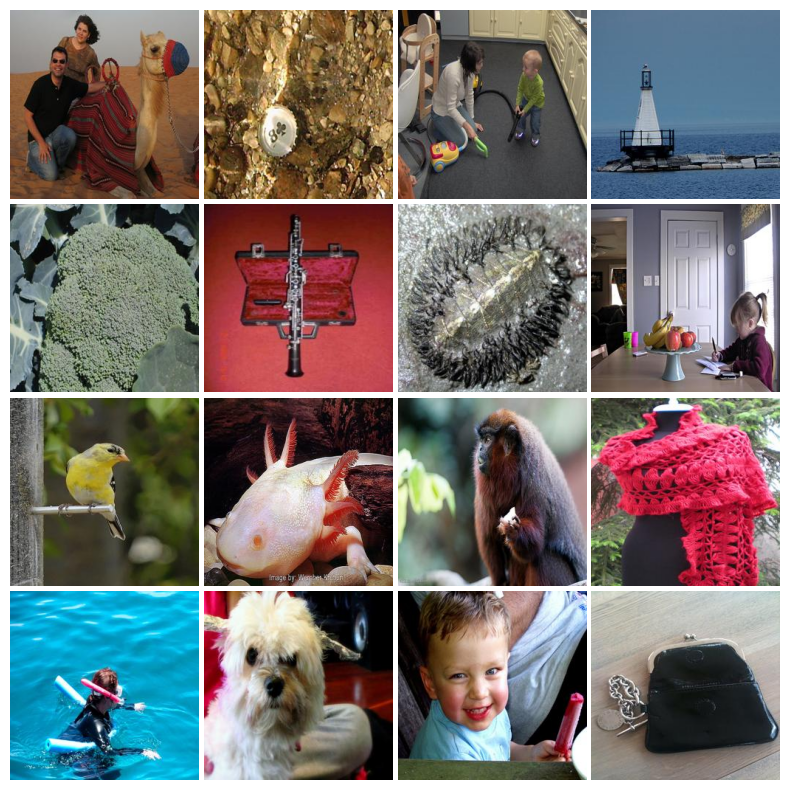

In [6]:
# Dá exemplo de imagens, para vermos se está tudo correto
batch = next(train_generator)
print(batch.shape)

# Plotar imagens
fig = plt.figure(figsize=(10, 10))
grid = ImageGrid(fig, 111, nrows_ncols=(4, 4), axes_pad=0.05)
for ax, img in zip(grid, batch):
    ax.imshow(img)
    ax.axis('off')
plt.show()

# Criando funções de aplicar máscara, serão utilizadas no processo de data Augmentation mais a frente

In [7]:
# Vamos agora utilizar essa imagens para treinar um modelo de inpainting, que vai tentar prever o buraco da imagem
# Para isso precisamos que além dessas imagens, tenhamos uma versão delas com buracos desenhados, para que o modelo 
# possa aprender a preencher esses buracos

# Vamos criar uma função que vai pegar uma imagem e desenhar um buraco nela, mas deve ser um buraco de formato e tamanho aleatório
# podendo ser até mais de um buraco, linha, curva ou qualquer outra coisa. Podemos usar funções do OpenCV para isso.

# Função para desenhar um buraco na imagem e retornar a imagem original com uma mascara preta.

import random

def random_mask(img, max_shapes=5):
    """
    Aplica uma máscara aleatória à imagem.
    
    Parâmetros:
    - img: imagem de entrada de tamanho 256x256x3
    - max_shapes: número máximo de formas aleatórias na máscara
    
    Retorna:
    - Imagem com regiões aleatórias faltantes
    """
    h, w, _ = img.shape
    mask = np.ones((h, w), np.uint8) * 255

    for _ in range(random.randint(1, max_shapes)):
        # Escolha aleatoriamente entre criar um polígono, linha ou curva
        shape_type = random.choice(['polygon', 'line', 'curve'])

        if shape_type == 'polygon':
            # Crie um polígono irregular
            vertices = np.array([[
                (random.randint(0, w), random.randint(0, h)) for _ in range(random.randint(3, 10))
            ]], dtype=np.int32)
            cv2.fillPoly(mask, vertices, 0)

        elif shape_type == 'line':
            # Crie uma linha aleatória
            pt1 = (random.randint(0, w), random.randint(0, h))
            pt2 = (random.randint(0, w), random.randint(0, h))
            cv2.line(mask, pt1, pt2, 0, thickness=random.randint(1, 5))

        elif shape_type == 'curve':
            # Crie uma curva (usando polígonos com poucos vértices)
            vertices = np.array([[
                (random.randint(0, w), random.randint(0, h)) for _ in range(random.randint(2, 4))
            ]], dtype=np.int32)
            cv2.polylines(mask, vertices, isClosed=False, color=0, thickness=random.randint(1, 5))

    # Aplica a máscara à imagem
    masked_img = cv2.bitwise_and(img, img, mask=mask)

    return masked_img


In [8]:
# uma versao mais simples só para desenhar linhas


def random_mask2(img, max_lines=5):
    """
    Aplica linhas aleatórias como máscara à imagem.
    
    Parâmetros:
    - img: imagem de entrada de tamanho 256x256x3
    - max_lines: número máximo de linhas aleatórias na máscara
    
    Retorna:
    - Imagem com linhas aleatórias faltantes
    """
    h, w, _ = img.shape
    mask = np.ones((h, w), np.uint8) * 255

    for _ in range(random.randint(4, max_lines)):
        # Crie uma linha aleatória
        pt1 = (random.randint(0, w), random.randint(0, h))
        pt2 = (random.randint(0, w), random.randint(0, h))
        cv2.line(mask, pt1, pt2, 0, thickness=random.randint(1, 5))

    # Aplica a máscara à imagem
    masked_img = cv2.bitwise_and(img, img, mask=mask)

    return masked_img

In [9]:
import cv2
import numpy as np
import random

def bezier_curve(points, num=1000):
    """
    Retorna uma curva bezier a partir de pontos de controle.
    """
    t_values = np.linspace(0, 1, num)
    curve = []
    N = len(points) - 1

    for t in t_values:
        x_val = sum([comb(N, i) * (1 - t) ** (N - i) * t ** i * point[0] for i, point in enumerate(points)])
        y_val = sum([comb(N, i) * (1 - t) ** (N - i) * t ** i * point[1] for i, point in enumerate(points)])
        curve.append((x_val, y_val))
    
    return curve


def random_mask3(img, max_lines=5, max_curves=4, use_seed=True):
    """
    Aplica linhas e curvas aleatórias como máscara à imagem.
    """
    if use_seed:
        np.random.seed(42) 

    h, w, _ = img.shape
    mask = np.ones((h, w), np.uint8) * 255

    # Desenhar linhas aleatórias
    for _ in range(random.randint(2, max_lines)):
        pt1 = (random.randint(0, w), random.randint(0, h))
        pt2 = (random.randint(0, w), random.randint(0, h))
        cv2.line(mask, pt1, pt2, 0, thickness=random.randint(1, 5))

    # Desenhar curvas aleatórias
    for _ in range(random.randint(2, max_curves)):
        num_points = random.randint(3, 4)  # 3 ou 4 pontos de controle
        points = [(random.randint(0, w), random.randint(0, h)) for _ in range(num_points)]
        curve = bezier_curve(points)
        for i in range(1, len(curve)):
            cv2.line(mask, (int(curve[i-1][0]), int(curve[i-1][1])), (int(curve[i][0]), int(curve[i][1])), 0, thickness=random.randint(1, 3))

    # Aplica a máscara à imagem
    masked_img = cv2.bitwise_and(img, img, mask=mask)

    return masked_img

from math import factorial

# Função auxiliar para calcular combinações (usada na curva bezier)
def comb(n, k):
    return factorial(n) / (factorial(k) * factorial(n - k))


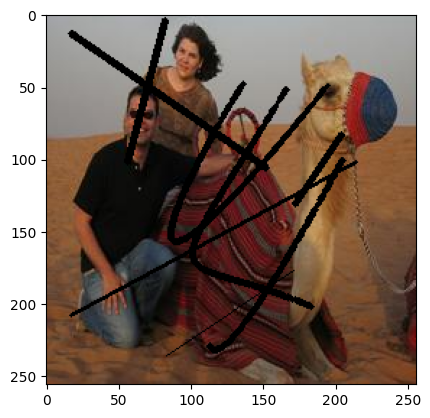

In [10]:
# testa a funcao
img = batch[0]
masked_img = random_mask3(img)
plt.imshow(masked_img)

# Criando classe de Augmentation que vai alimentar nosso modelo com batch de imagens mascaradas e não mascaradas ( originais ).

In [11]:
# Queria criar uma classe createAugmentation agora que usasse a funcao de criação de mascaras para em tempo real criar as imagens
# com buracos. 

# Vamos criar uma classe que vai pegar as imagens do gerador e aplicar a função de criação de buracos nelas, para que possamos
# treinar o modelo com as imagens com buracos.

## Ref: https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly.

## Seguindo a referência acima, criamos uma classe para gerar os dados de treino e teste, é um gerador de dados que além de tudo 
## aplica uma máscara aleatória nas imagens de treino, para que a rede aprenda a reconstruir a imagem original a partir da máscara.

class createAugment(keras.utils.Sequence):
    """
    Classe dedicada para data Augmentation, em especial para o problema de inpainting, criando máscaras.
    """
    def __init__(self, generator, batch_size=32, dim=(256, 256), n_channels=3, shuffle=True):
        self.generator = generator
        self.batch_size = batch_size 
        self.dim = dim
        self.n_channels = n_channels
        self.shuffle = shuffle
        
        self.on_epoch_end() # Inicializa os índices assim que o objeto é criado

    def on_epoch_end(self) -> None:
        """
        Inicializa ou re-inicializa os indexes após cada época, de preferencia com shuffle = True para o modelo desempenhar de forma robusta.
        """
        self.indexes = np.arange(len(self.generator))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __len__(self) -> int:
        """
        Retorna o número de batches por época
        """
        return len(self.generator)

    def __getitem__(self, index) -> tuple:
        """
        É passado um batch de índices para o gerador de dados, que retorna um batch de dados gerados a partir dos índices passados.
        """
        X_batch_original = self.generator[index]
        return self.__data_generation(X_batch_original)

    def __data_generation(self, X_batch_original) -> tuple:
        """ 
        Função que gera um batch de dados para treinamento a partir de um batch de índices. Os dados retornados são um batch de imagens
        mascaradas e um batch de imagens originais, para que o erro seja calculado a partir da imagem reconstruída.
        """
        X_batch = np.array([random_mask2(img) for img in X_batch_original])
        return X_batch, X_batch_original


augmented_train_generator = createAugment(train_generator, batch_size=32, dim=(256, 256), n_channels=3, shuffle=True)

## Definindo nossa métrica de coeficiente de dice e montando a arquitetura do modelo.

In [12]:
# Vídeo sobre a métrica do coeficiente de dice que vamos usar: https://www.youtube.com/watch?v=AZr64OxshLo
# Essa métrica é basicamente uma medida de o quanto essa imagem se parece com a original, ou seja, o quanto a imagem reconstruída
# se parece com a imagem original.
# Quanto mais próximo de 1, melhor.

def dice_coef(y_true, y_pred):
    y_true_f = keras.backend.flatten(y_true)
    y_pred_f = keras.backend.flatten(y_pred)
    intersection = keras.backend.sum(y_true_f * y_pred_f)
    
    return (2. * intersection) / (keras.backend.sum(y_true_f + y_pred_f))

In [13]:
class inpaintingModel:
  '''
  Fazendo uma UNET para o problema de inpainting. 
  '''
  def prepare_model(self, input_size=(256,256,3)):
    inputs = keras.layers.Input(input_size)

    conv0, pool0 = self.__ConvBlock(16, (3,3), (2,2), 'relu', 'same', inputs)  # Adicionado
    conv1, pool1 = self.__ConvBlock(32, (3,3), (2,2), 'relu', 'same', pool0) 
    conv2, pool2 = self.__ConvBlock(64, (3,3), (2,2), 'relu', 'same', pool1)
    conv3, pool3 = self.__ConvBlock(128, (3,3), (2,2), 'relu', 'same', pool2) 
    conv4, pool4 = self.__ConvBlock(256, (3,3), (2,2), 'relu', 'same', pool3) 
    
    conv5, up6 = self.__UpConvBlock(512, 256, (3,3), (2,2), (2,2), 'relu', 'same', pool4, conv4)
    conv6, up7 = self.__UpConvBlock(256, 128, (3,3), (2,2), (2,2), 'relu', 'same', up6, conv3)
    conv7, up8 = self.__UpConvBlock(128, 64, (3,3), (2,2), (2,2), 'relu', 'same', up7, conv2)
    conv8, up9 = self.__UpConvBlock(64, 32, (3,3), (2,2), (2,2), 'relu', 'same', up8, conv1)
    conv9, up10 = self.__UpConvBlock(32, 16, (3,3), (2,2), (2,2), 'relu', 'same', up9, conv0)  # Adicionado
    
    conv10 = self.__ConvBlock(16, (3,3), (2,2), 'relu', 'same', up10, False)  # Modificado
    
    outputs = keras.layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(conv10)

    return keras.models.Model(inputs=[inputs], outputs=[outputs]) 

  def __ConvBlock(self, filters, kernel_size, pool_size, activation, padding, connecting_layer, pool_layer=True):
    conv = keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(connecting_layer)
    conv = keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(conv)
    if pool_layer:
      pool = keras.layers.MaxPooling2D(pool_size)(conv)
      return conv, pool
    else:
      return conv

  def __UpConvBlock(self, filters, up_filters, kernel_size, up_kernel, up_stride, activation, padding, connecting_layer, shared_layer):
    conv = keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(connecting_layer)
    conv = keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(conv)
    up = keras.layers.Conv2DTranspose(filters=up_filters, kernel_size=up_kernel, strides=up_stride, padding=padding)(conv)
    up = keras.layers.concatenate([up, shared_layer], axis=3)

    return conv, up

In [14]:
keras.backend.clear_session()
model = inpaintingModel().prepare_model()
model.compile(optimizer='adam', loss='mean_absolute_error', metrics=[dice_coef])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 16  2320        ['conv2d[0][0]']                 
                                )                                                             

# Criando Callbacks que serão utilizadas mais a frente

In [15]:
# Criando callback para salvar os pesos do modelo no melhor ponto de validação e para parar o treinamento caso o modelo não melhore.

from keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint('best_weights.h5', save_best_only=True, monitor='val_loss', mode='min')


In [16]:
import pandas as pd
from tensorflow.keras.callbacks import Callback

class SaveMetricsCallback(Callback):
    def __init__(self, file_name="metrics.csv"):
        super(SaveMetricsCallback, self).__init__()
        self.file_name = file_name
        self.metrics_data = {"dice_coef": [], "loss": []}  # Aqui, estamos monitorando a função de perda e a métrica dice_coef

    def on_epoch_end(self, epoch, logs=None):
        self.metrics_data["dice_coef"].append(logs["dice_coef"])
        self.metrics_data["loss"].append(logs["loss"])  # Aqui, estamos pegando o valor da função de perda
        df = pd.DataFrame(self.metrics_data)
        df.to_csv(self.file_name, index=False)

callback_metrics = SaveMetricsCallback()

In [20]:
import os
import numpy as np
import cv2
from keras.callbacks import Callback
from matplotlib import pyplot as plt

class InpaintingVisualizer(Callback):
    def __init__(self, model, test_dir, output_dir, freq=5):
        super(InpaintingVisualizer, self).__init__()
        self.test_dir = test_dir
        self.freq = freq
        self.model = model
        self.output_dir = output_dir
        self.masked_images = []
        self.original_images = [os.path.join(test_dir, f) for f in os.listdir(test_dir) if 'original' in f]
        self.when_train_begin()
    
    def when_train_begin(self):
        for i in range(len(self.original_images)): 
            original_img = plt.imread(self.original_images[i])
            resized_original_img = cv2.resize(original_img, (256, 256)) / 255.0

            masked_img = random_mask3(resized_original_img, use_seed=True)
            self.masked_images.append(masked_img)
                
            # Criar o diretório se ele não existir
        if not os.path.exists(self.output_dir):
            os.makedirs(self.output_dir)

        

    def on_epoch_end(self, epoch, logs=None):
        if ((epoch + 1) % self.freq == 0) or (epoch == 0):
            self.visualize(epoch)

    def visualize(self, epoch):
        for i in range(len(self.original_images)): 
            
            original_img = plt.imread(self.original_images[i])
            resized_original_img = cv2.resize(original_img, (256, 256)) / 255.0

            masked_img = self.masked_images[i]
            
            # Aqui você deve adaptar para o seu método de preprocessamento
            inpainted_img = self.model.predict(masked_img.reshape(1, 256, 256, 3))
        
            
            fig, ax = plt.subplots(1, 3, figsize=(15, 5))
            ax[0].imshow(original_img)
            ax[0].set_title('Original')
            ax[0].axis('off')
            ax[1].imshow(masked_img)
            ax[1].set_title('Mascarada')
            ax[1].axis('off')  # Desativar os eixos para a imagem "Mascarada"
            ax[2].imshow(inpainted_img[0])
            ax[2].set_title('Inpainted')
            ax[2].axis('off')
           
            # Salvar a figura no diretório especificado
            filename = os.path.join(self.output_dir, f'epoch_{epoch + 1}_image_{i + 1}.png')
            plt.savefig(filename)
            plt.close(fig)  # Fecha a figura para liberar memória

# Instanciando o callback
image_saver = InpaintingVisualizer(model, test_dir='testes-originais_e_masked', output_dir='output-testes_controlados')


In [21]:
# recomendação do gpt para arrumar bug de callback
tf.config.experimental_run_functions_eagerly(True)

# Treinamento

In [22]:
_ = model.fit(augmented_train_generator, 
          workers = 1,
          use_multiprocessing = False,
          validation_data=test_generator, 
          epochs=100, 
          steps_per_epoch=len(train_generator),
          validation_steps=len(test_generator),
          callbacks=[checkpoint,callback_metrics, image_saver])

Epoch 1/100


c:\Users\mathe\miniconda3\envs\tf\lib\site-packages\tensorflow\python\data\ops\structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


22/22 [==============================] - 18s 802ms/step - loss: 0.1051 - dice_coef: 0.5762 - val_loss: 0.0000e+00 - val_dice_coef: 0.0000e+00
Epoch 2/100
22/22 [==============================] - 13s 595ms/step - loss: 0.0749 - dice_coef: 0.5909 - val_loss: 0.0000e+00 - val_dice_coef: 0.0000e+00
Epoch 3/100
22/22 [==============================] - 13s 597ms/step - loss: 0.0604 - dice_coef: 0.5996 - val_loss: 0.0000e+00 - val_dice_coef: 0.0000e+00
Epoch 4/100
22/22 [==============================] - 13s 598ms/step - loss: 0.0551 - dice_coef: 0.6040 - val_loss: 0.0000e+00 - val_dice_coef: 0.0000e+00
Epoch 5/100
22/22 [==============================] - 17s 779ms/step - loss: 0.0552 - dice_coef: 0.6040 - val_loss: 0.0000e+00 - val_dice_coef: 0.0000e+00
Epoch 6/100
22/22 [==============================] - 13s 605ms/step - loss: 0.0489 - dice_coef: 0.6060 - val_loss: 0.0000e+00 - val_dice_coef: 0.0000e+00
Epoch 7/100
22/22 [==============================] - 13s 604ms/step - loss: 0.0459 - dic

# Apresentando resultados

1/1 [==============================] - 0s 86ms/step


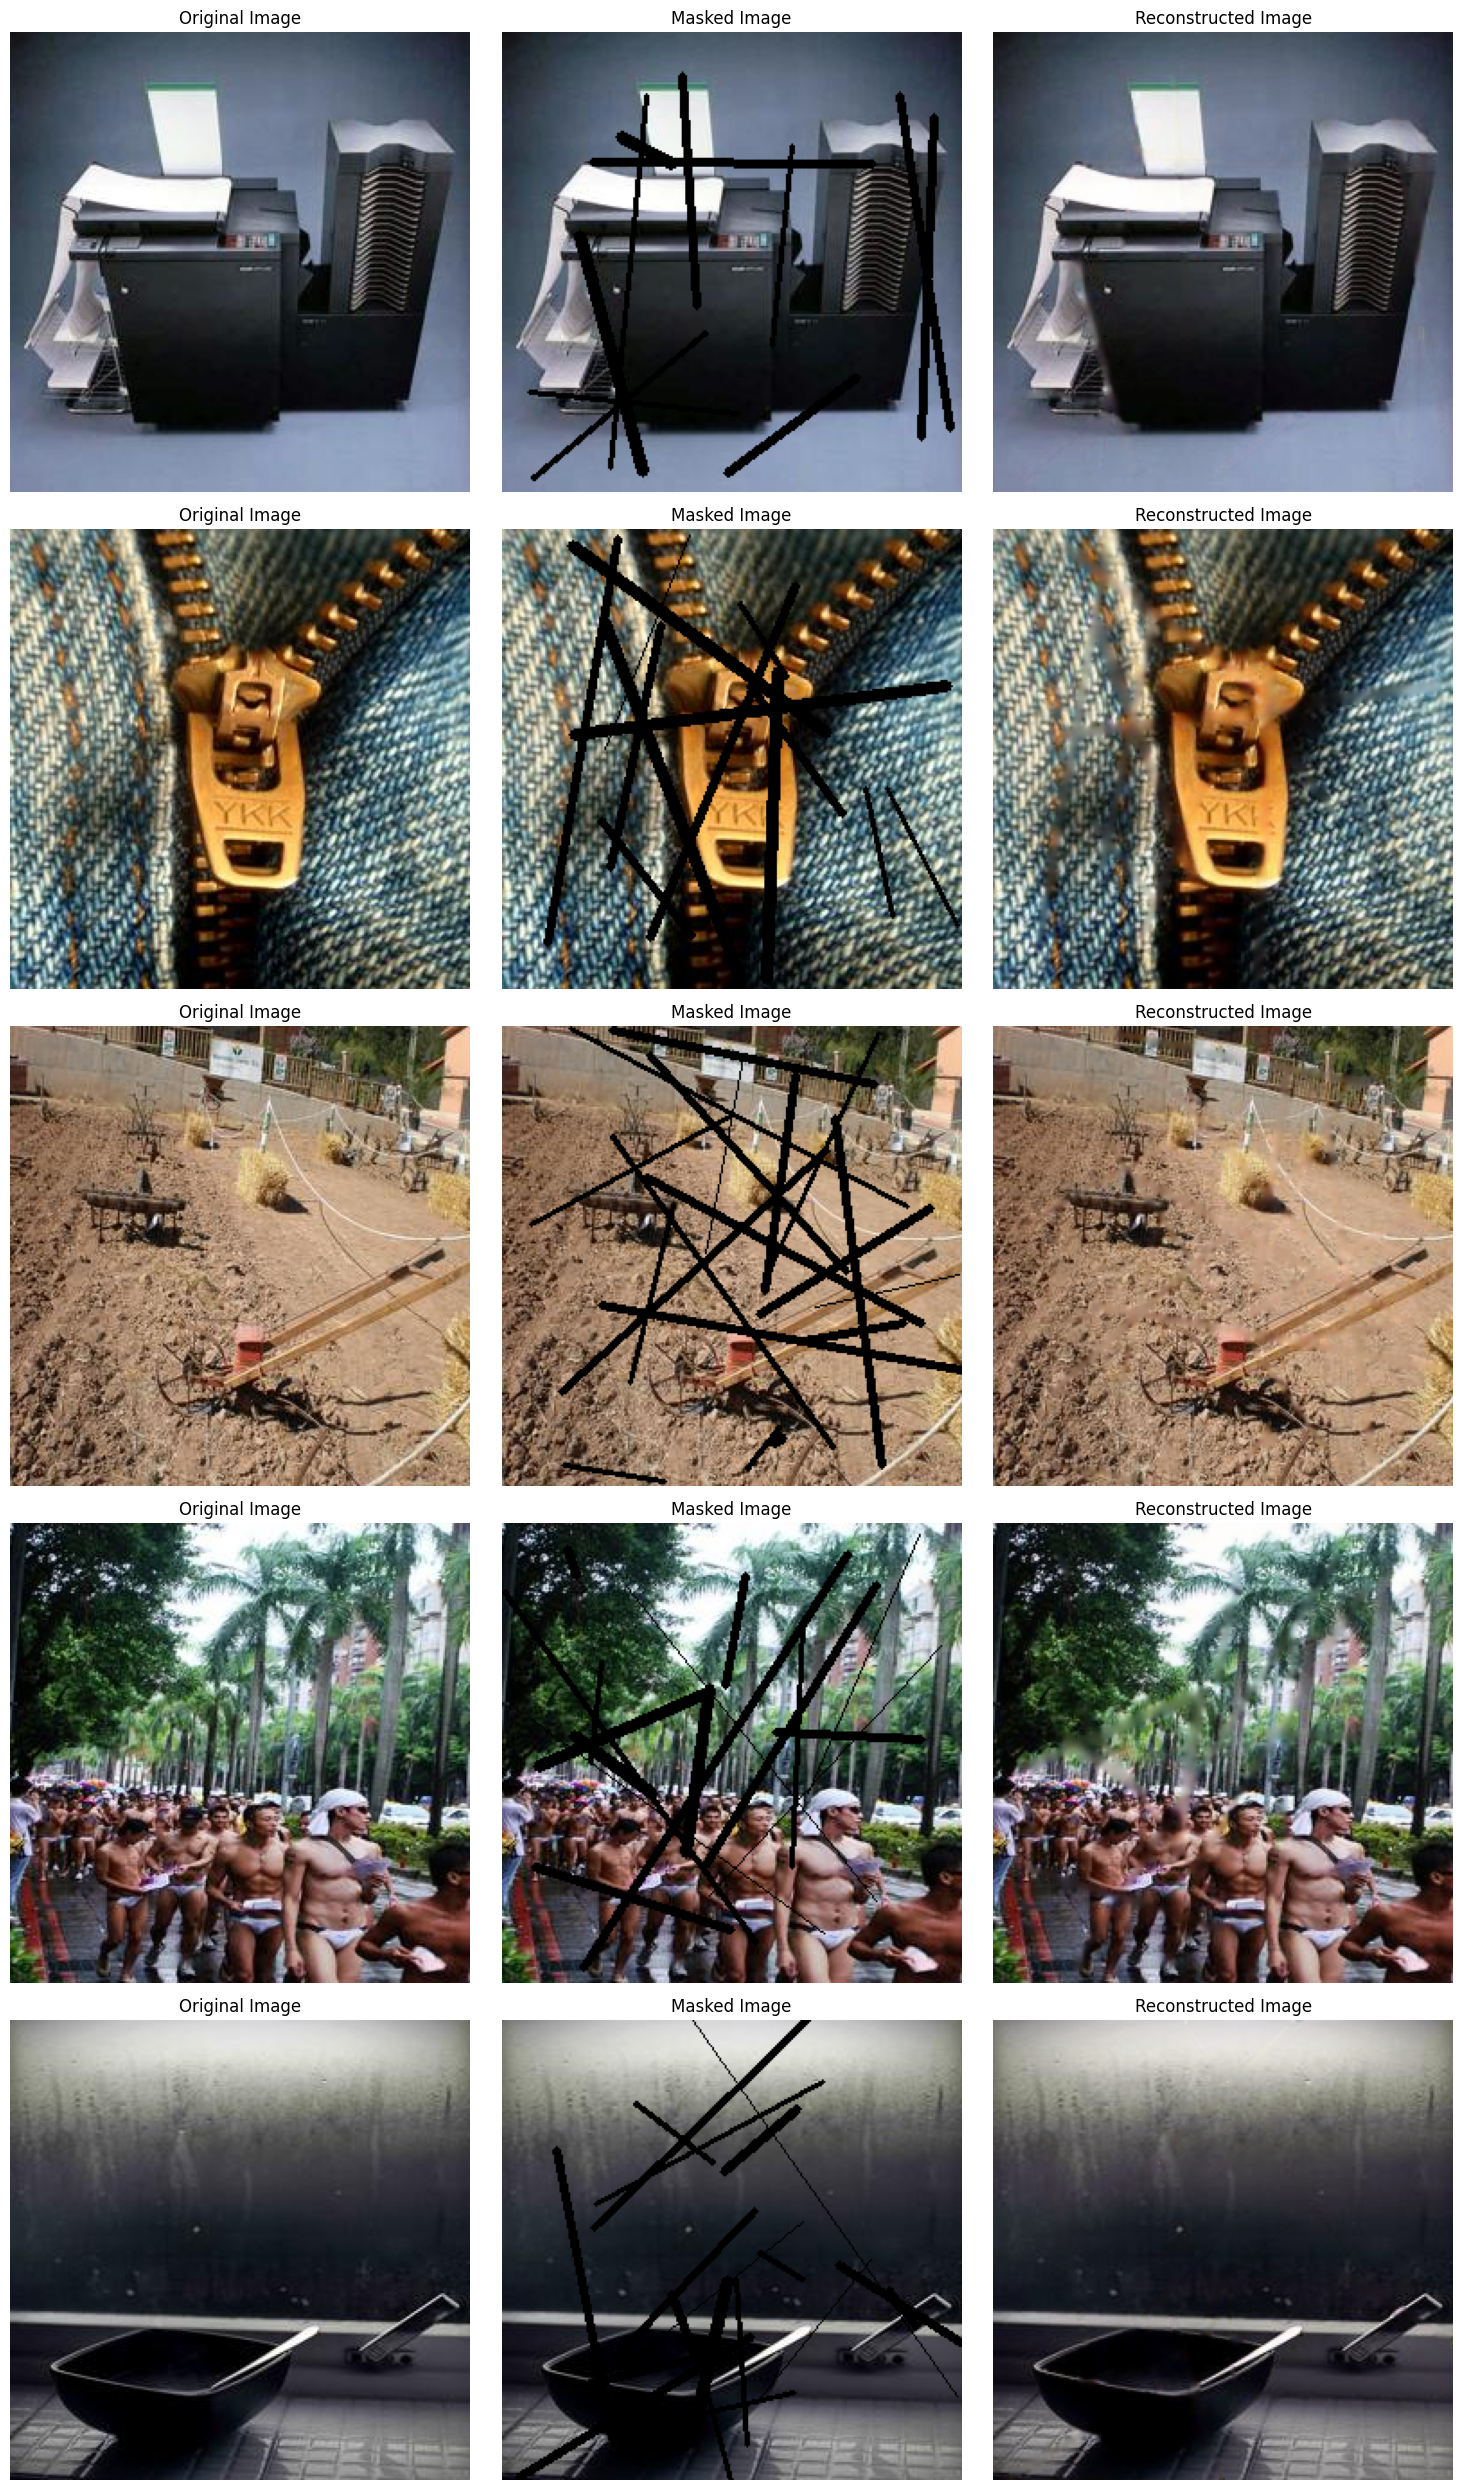

In [ ]:
import matplotlib.pyplot as plt

def plot_results(model, test_generator, num_samples=5):
    """
    Plota imagens originais, imagens mascaradas e imagens reconstruídas.
    
    Parâmetros:
    - model: Modelo treinado.
    - test_generator: Gerador de dados de teste.
    - num_samples: Número de amostras a serem plotadas.
    """
    
    # Pegar um batch de imagens do test_generator
    X_batch = test_generator.next()
    
    # Criar máscaras para as imagens
    X_masked = np.array([random_mask2(img, 20) for img in X_batch])
    
    # Usar o modelo para prever as imagens reconstruídas
    X_pred = model.predict(X_masked)
    
    # Plotar as imagens
    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5*num_samples))
    
    for i in range(num_samples):
        axes[i, 0].imshow(X_batch[i])
        axes[i, 0].set_title("Original Image")
        axes[i, 0].axis('off')
        
        axes[i, 1].imshow(X_masked[i])
        axes[i, 1].set_title("Masked Image")
        axes[i, 1].axis('off')
        
        axes[i, 2].imshow(X_pred[i])
        axes[i, 2].set_title("Reconstructed Image")
        axes[i, 2].axis('off')
    
    plt.tight_layout()
    plt.show()

# Chamar a função 
plot_results(model, test_generator)


In [ ]:
def save_results(model, test_generator, save_dir, num_samples=100):
    """
    Salva imagens originais, imagens mascaradas e imagens reconstruídas em um diretório especificado.
    
    Parâmetros:
    - model: Modelo treinado.
    - test_generator: Gerador de dados de teste.
    - save_dir: Diretório onde as imagens serão salvas.
    - num_samples: Número de amostras a serem salvas.
    """
    
    # Criar o diretório se ele não existir
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    
    samples_saved = 0
    
    while samples_saved < num_samples:
        # Pegar um batch de imagens do test_generator
        X_batch = test_generator.next()
        batch_size = X_batch.shape[0]
        
        # Criar máscaras para as imagens
        X_masked = np.array([random_mask3(img) for img in X_batch])
        
        # Usar o modelo para prever as imagens reconstruídas
        X_pred = model.predict(X_masked)
        
        for i in range(batch_size):
            if samples_saved >= num_samples:
                break
            
            fig, axes = plt.subplots(1, 3, figsize=(15, 5))
            
            axes[0].imshow(X_batch[i])
            axes[0].set_title("Original Image")
            axes[0].axis('off')
            
            axes[1].imshow(X_masked[i])
            axes[1].set_title("Masked Image")
            axes[1].axis('off')
            
            axes[2].imshow(X_pred[i])
            axes[2].set_title("Reconstructed Image")
            axes[2].axis('off')
            
            # Salvar a figura
            filename = os.path.join(save_dir, f"sample_{samples_saved+1}.png")
            plt.tight_layout()
            plt.savefig(filename)
            
            # Fechar a figura para liberar memória
            plt.close(fig)
            
            samples_saved += 1

# Chamar a função 
save_dir = "C:/Users/mathe/Desktop/facul/Projeto-Final/outputs/Inpainting-enconder-decoder-v2"  # Substitua pelo caminho desejado
save_results(model, test_generator, save_dir)


1/1 [==============================] - 0s 86ms/step


In [ ]:
# quero fazer testes, caminhos das imagens:
original_path = "C:/Users/mathe/Desktop/facul/Projeto-Final/manual_tests/img3-original.jpg"
masked_path = "C:/Users/mathe/Desktop/facul/Projeto-Final/manual_tests/img3-masked.jpg"
output_path = "C:/Users/mathe/Desktop/facul/Projeto-Final/manual_tests/img3-output.jpg"

1/1 [==============================] - 0s 82ms/step


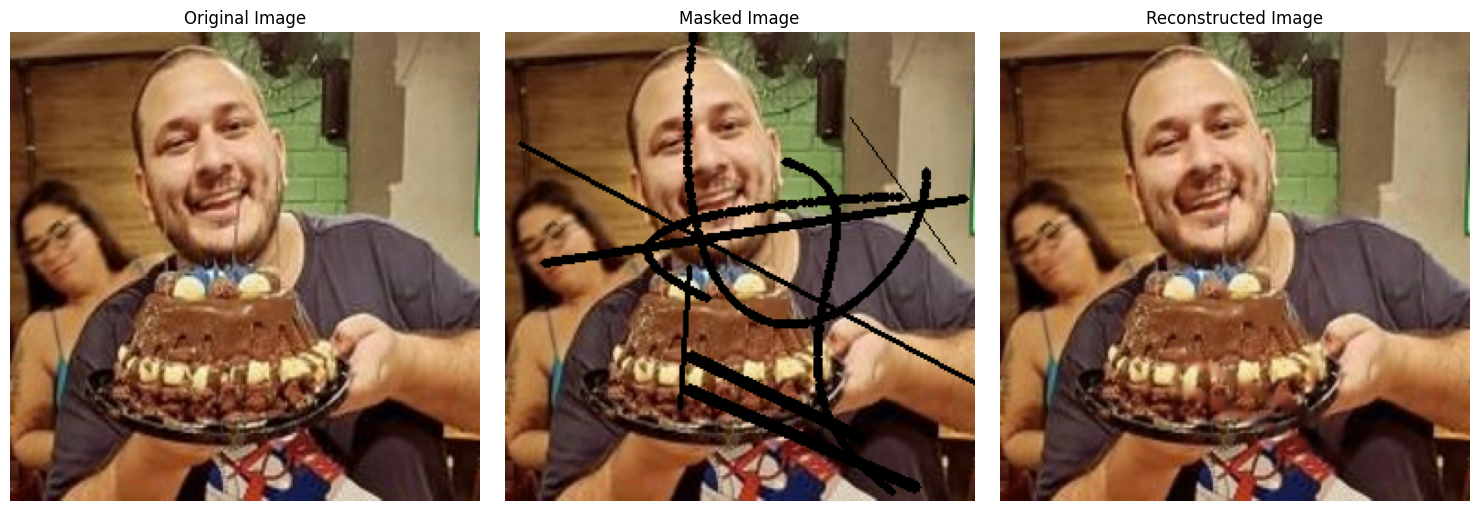

In [ ]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from PIL import Image


def test_custom_image(model, original_path, output_path):
    # Carregar imagem original usando PIL
    original_img = Image.open(original_path).resize((256, 256))
    original_array = np.array(original_img) / 255.0
    
    # Aplicar máscara na imagem original
    masked_array = random_mask3(original_array, 20)
    
    # Expandir dimensões para se adequar ao formato de entrada do modelo (batch_size, height, width, channels)
    masked_array = np.expand_dims(masked_array, axis=0)
    
    # Usar o modelo para prever a imagem reconstruída
    predicted_array = model.predict(masked_array)
    
    # Converter o array previsto de volta para uma imagem
    predicted_img = Image.fromarray((predicted_array[0] * 255).astype(np.uint8))
    
    # Salvar a imagem reconstruída
    predicted_img.save(output_path)
    
    # Plotar as imagens
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    axes[0].imshow(original_array)
    axes[0].set_title("Original Image")
    axes[0].axis('off')
    
    axes[1].imshow(masked_array[0])
    axes[1].set_title("Masked Image")
    axes[1].axis('off')
    
    axes[2].imshow(predicted_array[0])
    axes[2].set_title("Reconstructed Image")
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()

# testando 
test_custom_image(model, original_path, output_path)
